<a href="https://colab.research.google.com/github/weasel-codes/channel-pruning/blob/main/FINAL_of_L1_PECSS_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries

In [ ]:
# %%capture
!pip install tf-explain
!pip install kerassurgeon
!pip install kerop

     |████████████████████████████████| 51kB 2.1MB/s 
     |████████████████████████████████| 286kB 4.0MB/s 
     |████████████████████████████████| 2.2MB 11.9MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: importlib-metadata 4.0.1
    Uninstalling importlib-metadata-4.0.1:
      Successfully uninstalled importlib-metadata-4.0.1
  Found existing installation: pluggy 0.7.1
    Uninstalling pluggy-0.7.1:
      Successfully uninstalled pluggy-0.7.1
  Found existing installation: pytest 3.6.4
    Uninstalling pytest-3.6.4:
      Successfully uninstalled pytest-3.6.4
  Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2


  Created wheel for kerop: filename=kerop-0.1.4.post2105220853-cp37-none-any.whl size=5822 sha256=100ea0b96c4481f7d205eb76b21013aa9c24c87a5d17adfa99ec84c6690a6ad1
  Stored in directory: /root/.cache/pip/wheels/52/14/1c/ac2ee932faa6bc904b26430a266195a515ccaa79f73a258b88
Successfully built kerop


In [ ]:
%tensorflow_version 1.x
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import math

from kerassurgeon import Surgeon
from kerassurgeon import identify
from keras.preprocessing.image import load_img
from keras.applications.imagenet_utils import preprocess_input
from kerassurgeon.operations import delete_channels, delete_layer
from keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import time
%matplotlib inline

TensorFlow 1.x selected.


Using TensorFlow backend.


In [ ]:
print(tf.__version__)

1.15.2


In [ ]:
import kerop

## Dataset Import 

In [ ]:
path = '/content/drive/MyDrive/ML/pecss/pecss_dataset/dataset'

## Data Preprocessing

### Generate Model

In [ ]:
def getModel() :
  model = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=True)
  model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
  # model.summary()
  return model

In [ ]:
test_model = getModel()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


553467904/553467096 [==============================] - 6s 0us/step


### Get type of layer, given layer name

In [ ]:
def getLayerType(layer_name) : 

  if 'conv' in layer_name :
    return 'conv'
  elif 'pool' in layer_name :
    return 'pool'
  elif 'input' in layer_name :
    return 'input'
  elif 'flatten' in layer_name :
    return 'flatten'
  elif 'fc' in layer_name :
    return 'dense'
  else :
    return 'output'


### Calculate flops

In [ ]:
def modelFlops(test_model) :
  # analyze FLOPS
  layer_name, layer_flops, inshape, weights = kerop.profile(test_model)

  flops = 0
  # visualize results
  for name, flop, shape, weight in zip(layer_name, layer_flops, inshape, weights):
      flops = flops + flop

  return flops

## Layer Wise Pruning

### Prune Function
> Needs Rate as parameter

In [ ]:
def prune(r) :# r = rate of pruning
  model = getModel()
  layers = model.layers
  layer_count = len(layers)
  layer_details = []*layer_count

  for i in range(layer_count) :
    layer = layers[i]                                           # Each layer
    layer_name = layer.name
    layer_type = getLayerType(layer_name)
    weights = layer.get_weights()                               # Ger Parameters
    layer_details.append([i, layer_type, layer_name, weights])  # Add to array consisting of layer info

  for i in range(layer_count):                    # num_del_layer_wise is declared above
    weights_dic={}                                # dictionary with filter index as key and filter details as value

    if layer_details[i][1] != 'conv' :            # If lyaer is not conv, append 0 to array
      layer_details[i].append(0)                  # 0 filters to prune in case of non conv layer
      layer_details[i].append([])                 # Null array appended as no sorted filter
      continue

    weight = layer_details[i][3]                  # If layer is conv, compute l1 norm of each filter
    num_filters = len(weight[0][0][0])            # weight[i] : weights or biases, weights[i][i] = r,g,b, weights[i][i][i] = weights corresponding to r,g,b
    num_del_layer_wise = round(num_filters*r)     # 'r' decides what ratio of filters are needed to be deleted

    for j in range(num_filters):                  # For each filter in conv layer, calculate L1 norm
      w_s = np.sum(abs(weight[0][0][0][j]))
      filt = j                                    
      weights_dic[filt] = w_s                     # Filter wise details for each layer

    sorted_n1_weights = sorted(weights_dic.items(), key=lambda kv: kv[1])

    layer_details[i].append(num_del_layer_wise)
    layer_details[i].append(sorted_n1_weights)

  # print("L1 norm of layer {} with type {} and no of filters : {} \n".format(i, layer_details[i][1], len(weights_dic)), sorted_n1_weights)
  # print(len(layer_details[i]))

  print("Pruning for rate : ", r)
  new_model = model
  for i in range(layer_count) :
    total_channel_to_delete = layer_details[i][4]
    if layer_details[i][1] == 'conv' and total_channel_to_delete > 0:
      # print("#################### Processing Layer number : ", i)

      surgeon = Surgeon(new_model)
      channel_to_delete = []

      for j in range(total_channel_to_delete) :
        channel_num = layer_details[i][5][j][0]
        channel_to_delete.append(channel_num)
      # print(i, "", total_channel_to_delete ,"", channel_to_delete)

      surgeon.add_job('delete_channels', new_model.layers[i], channels=channel_to_delete)
      new_model = surgeon.operate()

      # print("#################### Pruning Completed for Layer number : ", i)
      # print()

  print("Initial parameters : ", (model.count_params()))
  print("After pruning parameters : ", (new_model.count_params()))
  print("Pruned parameters : ", (model.count_params() - new_model.count_params()))
  return new_model

### Define Before pruning

In [ ]:
#Before prune
def beforePruning() :
  test_model = getModel()

  pred = []
  total_time = 0

  test_model.summary()
  for filename in os.listdir(path) :
    label = filename.split('_')[0]
    file_path = path + "/" + filename

    x=time.time()
    
    image=load_img(file_path, target_size=(224, 224))  # reading image (Folder path and image name )
    
    image=np.array(image)
    image=image.reshape((1,image.shape[0],image.shape[1],image.shape[2]))
    image=preprocess_input(image)

    op1=test_model.predict(image)
    label1=decode_predictions(op1,top=1)

    y=time.time()
    total_time = total_time + (y-x)

    pred.append([label, label1[0][0][0]])

  count = 0
  for i in range(len(pred)) :
    if pred[i][0] == pred[i][1] :
      count = count + 1

  print('Total : ', len(pred), ', Correct : ', count, ', Accuracy : ', (100*count/len(pred)))
  print('Time Taken for prediction : ', (total_time/len(pred)) )
  print('Model Flops : ', modelFlops(test_model))
  test_model.save("test_vgg16")
  print("Model size after pruning=>",(os.stat('/content/test_vgg16').st_size)/math.pow(2,20)," Mega Bytes")

### Define After Pruning

In [ ]:
# After pruning
def afterPruning(rate, dic) :
  j = 0
  for r in rate :
    vals = []
    j=j+1
    total_time = 0
    pred = []
    new_model = prune(r)
    new_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

    for filename in os.listdir(path) :
        label = filename.split('_')[0]
        file_path = path + "/" + filename
        image=load_img(file_path, target_size=(224, 224))  # reading image (Folder path and image name )
        
        x=time.time()
        image=np.array(image)
        image=image.reshape((1,image.shape[0],image.shape[1],image.shape[2]))
        image=preprocess_input(image)

        op1=new_model.predict(image)
        y=time.time()
        total_time = total_time + (y-x)
        label1=decode_predictions(op1,top=1)
        pred.append([label, label1[0][0][0]])

    count = 0
    for i in range(len(pred)) :
      if pred[i][0] == pred[i][1] :
        count = count + 1
    
    print("Model Summary after printing : ")
    new_model.summary()
    print()
    print("####### FOR RATE : ", r)
    accuracy = (100*count/len(pred))
    print('Total : ', len(pred), ', Correct : ', count, ', Accuracy : ', accuracy)
    t = (total_time/len(pred))
    print('Time Taken for prediction : ',  t)

    flops = modelFlops(new_model)
    print('Model Flops : ', flops)

    new_model.save(("vgg16_" + str(j)))
    frm = "/content/vgg16_" + str(j)
    size = (os.stat(frm).st_size)/math.pow(2,20)
    print("Model size after pruning=>", size," Mega Bytes")

    vals.append(accuracy) # Accuracy
    vals.append(t)        # Time
    vals.append(flops)    # FLOPS 
    vals.append(size)     # Size
    dic[r] = vals
    print("####### DONE RATE : ", r)

### Calculate Before Pruning Details

In [ ]:
beforePruning()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### Calculate After Pruning Details

In [ ]:
multilayer_dic = {}
afterPruning(rate = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08], dic = multilayer_dic)
print(multilayer_dic)

Pruning for rate :  0.01
Deleting 1/64 channels from layer: block1_conv2
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Deleting 1/128 channels from layer: block2_conv1
Deleting 1/128 channels from layer: block2_conv2
Deleting 1/256 channels from layer: block3_conv1
Deleting 3/256 channels from layer: block3_conv2
Deleting 3/256 channels from layer: block3_conv3
Deleting 3/512 channels from layer: block4_conv1
Deleting 5/512 channels from layer: block4_conv2
Deleting 5/512 channels from layer: block4_conv3
Deleting 5/512 channels from layer: block5_conv1
Deleting 5/512 channels from layer: block5_conv2
Deleting 5/512 channels from layer: block5_conv3
Initial parameters :  138357544
After pruning parameters :  137082213
Pruned parameters :  1275331
Model Summary after printing : 
Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64

In [ ]:
multilayer_dic = {}
afterPruning(rate = [0.08, 0.09, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16], dic = multilayer_dic)
multilayer_dic

Pruning for rate :  0.08
Deleting 5/64 channels from layer: block1_conv2
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Deleting 5/128 channels from layer: block2_conv1
Deleting 10/128 channels from layer: block2_conv2
Deleting 10/256 channels from layer: block3_conv1
Deleting 20/256 channels from layer: block3_conv2
Deleting 20/256 channels from layer: block3_conv3
Deleting 20/512 channels from layer: block4_conv1
Deleting 41/512 channels from layer: block4_conv2
Deleting 41/512 channels from layer: block4_conv3
Deleting 41/512 channels from layer: block5_conv1
Deleting 41/512 channels from layer: block5_conv2
Deleting 41/512 channels from layer: block5_conv3
Initial parameters :  138357544
After pruning parameters :  128051464
Pruned parameters :  10306080
40960/35363 [==================================] - 0s 0us/step
Model Summary after printing : 
Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
________________________________________

{0.08: [98.83720930232558,
  0.10537221819855445,
  27169123281,
  488.55807876586914],
 0.09: [97.67441860465117,
  0.026806382245795672,
  26597615857,
  483.74410247802734],
 0.1: [100.0, 0.025947548622308775, 26216161797, 478.976749420166],
 0.11: [97.67441860465117,
  0.03043190268583076,
  25769940714,
  474.2705421447754],
 0.12: [97.67441860465117,
  0.03346396047015523,
  25271639292,
  469.5092658996582],
 0.13: [94.18604651162791,
  0.03493872631427854,
  24866417876,
  463.90422439575195],
 0.14: [97.67441860465117,
  0.041691319887028185,
  24376252022,
  459.1629981994629],
 0.15: [89.53488372093024,
  0.04489781690198322,
  23944192331,
  454.4930839538574],
 0.16: [84.88372093023256,
  0.04612345196479975,
  23582840815,
  449.78018951416016]}

## Whole Model Pruning

In [ ]:
model = getModel()
layer1 = model.layers[1]
layer2 = model.layers[2]
layer4 = model.layers[4]
layer5 = model.layers[5]
layer7 = model.layers[7]
layer8 = model.layers[8]
layer9 = model.layers[9]
layer11= model.layers[11]
layer12= model.layers[12]
layer13 = model.layers[13]
layer15 =model.layers[15]
layer16 =model.layers[16]
layer17 =model.layers[17]

layer1_weights = layer1.get_weights()
layer2_weights = layer2.get_weights()
layer4_weights = layer4.get_weights()
layer5_weights = layer5.get_weights()
layer7_weights = layer7.get_weights()
layer8_weights = layer8.get_weights()
layer9_weights = layer9.get_weights()
layer11_weights = layer11.get_weights()
layer12_weights = layer12.get_weights()
layer13_weights = layer13.get_weights()
layer15_weights = layer15.get_weights()
layer16_weights = layer16.get_weights()
layer17_weights = layer17.get_weights()

conv_layer_weights=[layer1_weights,layer2_weights,layer4_weights,layer5_weights,layer7_weights,layer8_weights,
                    layer9_weights,layer11_weights,layer12_weights,layer13_weights,layer15_weights,layer16_weights,layer17_weights]

In [ ]:
weights_dic_sort={}
for i in range(len(conv_layer_weights)):
  weight=conv_layer_weights[i]
  num_filters=len(weight[0][0][0])

  for j in range(num_filters):
    w_s=np.sum(abs(weight[0][0][0][j]))
    filt=i+1,j #'filt_{}'.format(j)
    weights_dic_sort[filt]=w_s

weights_dic_sort_item=sorted(weights_dic_sort.items(),key=lambda kv: kv[1])
print("L1 norm of all conv_layer is\n", weights_dic_sort_item)
print("Length of weights_dic_sort_item is :", len(weights_dic_sort_item))

L1 norm of all conv_layer is
 [((4, 43), 0.2002542), ((4, 123), 0.48433247), ((4, 69), 0.49664518), ((2, 24), 0.6581166), ((4, 49), 0.77571857), ((4, 0), 0.8334694), ((2, 50), 0.9232044), ((4, 27), 0.92957157), ((2, 1), 0.9824326), ((4, 92), 1.0233094), ((2, 32), 1.0302942), ((2, 40), 1.0342686), ((4, 77), 1.0508535), ((2, 55), 1.0619622), ((2, 29), 1.0631223), ((2, 22), 1.066886), ((4, 89), 1.0750475), ((4, 121), 1.109404), ((4, 115), 1.1135979), ((3, 14), 1.1140071), ((4, 53), 1.1305283), ((4, 1), 1.1421769), ((2, 6), 1.156751), ((4, 100), 1.1598878), ((2, 36), 1.1601743), ((2, 2), 1.1668885), ((4, 39), 1.1765716), ((2, 27), 1.1791456), ((2, 17), 1.1795201), ((2, 52), 1.1899108), ((4, 67), 1.193792), ((2, 16), 1.2043507), ((2, 38), 1.2086673), ((4, 74), 1.2255552), ((4, 124), 1.2268746), ((6, 149), 1.2289463), ((4, 105), 1.2309102), ((2, 19), 1.2625873), ((4, 57), 1.2644165), ((2, 25), 1.2721324), ((4, 108), 1.280556), ((4, 31), 1.2938404), ((2, 9), 1.306928), ((4, 120), 1.309341), (

In [ ]:
def afterPruneWhole(r) :
  val = []
  num_channels_to_delete_overall=round(len(weights_dic_sort_item)*r)
  num_channels_to_delete_overall

  dic_layer={}
  for i in range(num_channels_to_delete_overall):
    if weights_dic_sort_item[i][0][0] not in dic_layer:
      dic_layer[weights_dic_sort_item[i][0][0]]=[]
      dic_layer[weights_dic_sort_item[i][0][0]].append(weights_dic_sort_item[i][0][1])
    else:
      dic_layer[weights_dic_sort_item[i][0][0]].append(weights_dic_sort_item[i][0][1])

  new_model_w = getModel()

  dic_layer_sorted={}
  for key,value in dic_layer.items():
    dic_layer_sorted[key]=sorted(value)

  layer=[1,2,4,5,7,8,9,11,12,13,15,16,17]
  for key, value in dic_layer_sorted.items():
    if key!=0:
      print(key)
      surgeon = Surgeon(new_model_w)
      surgeon.add_job('delete_channels', new_model_w.layers[layer[key]], channels=value)
      new_model_w = surgeon.operate()

  new_model_w.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
  new_model_w.summary()

  pred_w = []
  total_time = 0
  for filename in os.listdir(path):
      label = filename.split('_')[0]
      file_path = path + "/" + filename

      x=time.time()
      image=load_img(file_path, target_size=(224, 224))  # reading image (Folder path and image name )
        
      image=np.array(image)
      image=image.reshape((1,image.shape[0],image.shape[1],image.shape[2]))
      image=preprocess_input(image)

      op1=new_model_w.predict(image)
      y=time.time()
      total_time = total_time + (y-x)
      label1=decode_predictions(op1,top=1)
      pred_w.append([label, label1[0][0][0]])

  count = 0
  for i in range(len(pred_w)):
    if pred_w[i][0] == pred_w[i][1] :
      count = count + 1


  j = r

  print("####### FOR RATE : ", r)
  accuracy = (100*count/len(pred_w))
  print('Total : ', len(pred_w), ', Correct : ', count, ', Accuracy : ', accuracy)

  t = (total_time/len(pred_w))
  print('Time Taken for prediction : ',  t)

  flops = modelFlops(new_model_w)
  print('Model Flops : ', flops)

  new_model_w.save(("vgg16_" + str(j)))
  frm = "/content/vgg16_" + str(j)
  size = (os.stat(frm).st_size)/math.pow(2,20)
  print("Model size after pruning=>", size," Mega Bytes")

  val.append(accuracy) # Accuracy
  val.append(t)        # Time
  val.append(flops)    # FLOPS 
  val.append(size)     # Size
  return val

In [ ]:
whole_prune = {}
r = [0.01, 0.02, 0.03, 0.04, 0.05]
for rate in r :
  val = afterPruneWhole(rate)
  whole_prune[rate] = val

print(whole_prune)

4
Deleting 19/256 channels from layer: block3_conv1
2
Deleting 16/128 channels from layer: block2_conv1
3
Deleting 1/128 channels from layer: block2_conv2
6
Deleting 1/256 channels from layer: block3_conv3
Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 112)     64624     
__________________________________________________

## Printing Graphs

Collected here are readings coming out through processing done above

multi_param :  15
multi_rate :  15
multi_acc 15
multi_size 15
multi_flops 15


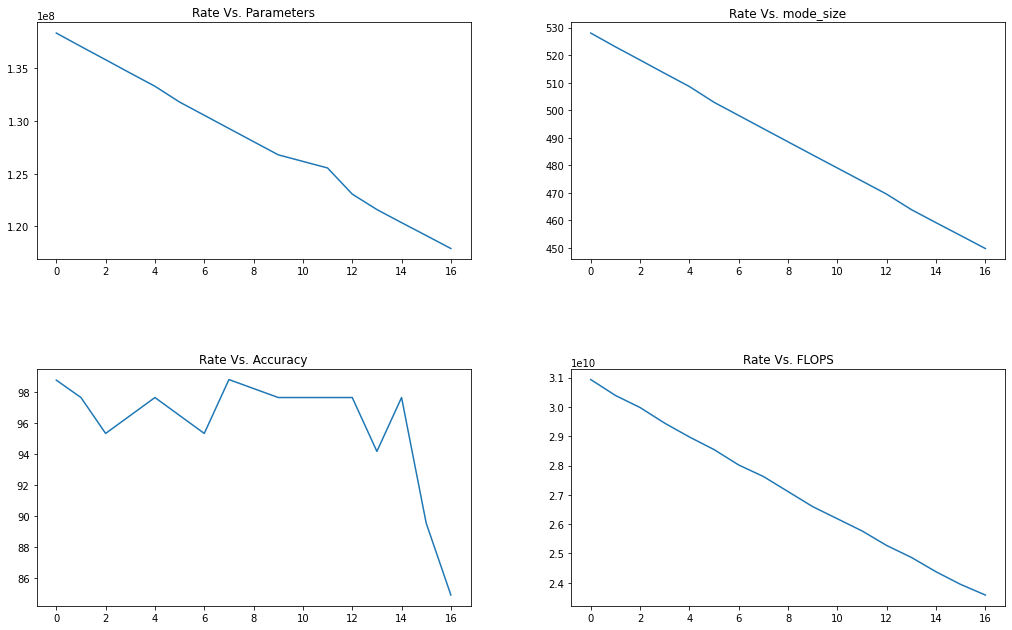

In [ ]:
multi_dic = {0.01: [97.67441860465117, 0.02598285675048828, 30390582674, 523.0066719055176], 
 0.02: [95.34883720930233, 0.02551015587740166, 29978173943, 518.2075271606445], 
 0.03: [96.51162790697674, 0.03013679315877515, 29444253833, 513.3612442016602], 
 0.04: [97.67441860465117, 0.03234128064887468, 28973985902, 508.5925178527832], 
 0.05: [96.51162790697674, 0.03356709313947101, 28543729797, 502.8610649108887], 
 0.06: [95.34883720930233, 0.03934561374575593, 28017684184, 498.0858497619629], 
 0.07: [98.83720930232558, 0.04006469804187154, 27625907196, 493.29065322875977], 
 0.08: [98.83720930232558, 0.10537221819855445, 27169123281, 488.55807876586914],
 0.09: [97.67441860465117, 0.02680638224579567, 26597615857, 483.74410247802734],
 0.11: [97.67441860465117, 0.03043190268583076, 25769940714, 474.2705421447754],
 0.12: [97.67441860465117, 0.03346396047015523, 25271639292, 469.5092658996582],
 0.13: [94.18604651162791, 0.03493872631427854, 24866417876, 463.90422439575195],
 0.14: [97.67441860465117, 0.04169131988702818, 24376252022, 459.1629981994629],
 0.15: [89.53488372093024, 0.04489781690198322, 23944192331, 454.4930839538574],
 0.16: [84.88372093023256, 0.04612345196479975, 23582840815, 449.78018951416016]}


multi_total_param = [138357544, 137082213, 135824111, 134553649, 133303521, 131801014, 130549183, 
               129292115, 128051464, 126789469, 125539700, 124305961, 123057783, 121588415, 
               120345493, 119121258, 117886267]

multi_param = [138357544, 137082213, 135824111, 134553649, 133303521, 131801014, 130549183, 
               129292115, 126789469, 125539700, 123057783, 121588415, 
               120345493, 119121258, 117886267]
multi_rate = [0, 1, 2, 3, 4, 5, 6, 7, 9, 11, 12, 13, 14, 15, 16]
multi_acc = [98.8]
multi_size = [528]
multi_flops = [30932349056]

for rate in [1, 2, 3, 4, 5, 6, 7, 9, 11, 12, 13, 14, 15, 16] :
  multi_acc.append(multi_dic[rate/100][0])
  multi_size.append(multi_dic[rate/100][3])
  multi_flops.append(multi_dic[rate/100][2])

print("multi_param : ", len(multi_param))
print("multi_rate : ", len(multi_rate))
print("multi_acc", len(multi_acc))
print("multi_size", len(multi_size))
print("multi_flops", len(multi_flops))

fig, a =  plt.subplots(2,2)
a[0][0].plot(multi_rate, multi_param)
a[0][0].set_title('Rate Vs. Parameters')
a[0][1].plot(multi_rate, multi_size)
a[0][1].set_title('Rate Vs. mode_size')
a[1][1].plot(multi_rate, multi_flops)
a[1][1].set_title('Rate Vs. FLOPS')
a[1][0].plot(multi_rate, multi_acc)
a[1][0].set_title('Rate Vs. Accuracy')
fig.tight_layout()
fig.set_size_inches(15, 10)
plt.show()

In [ ]:
 whole_dic = {0.01: [96.51162790697674, 0.026442477869433025, 29766528475, 527.477222442627],
              0.02: [94.18604651162791, 0.02970767298410105, 28681089846, 526.9682464599609], 
              0.03: [84.88372093023256, 0.032492468523424724, 27850796177, 526.2290382385254], 
              0.04: [67.44186046511628, 0.03327870646188425, 27028080651, 525.4679756164551], 
              0.05: [62.7906976744186, 0.03813223228898159, 26286960710, 524.6554679870605]}

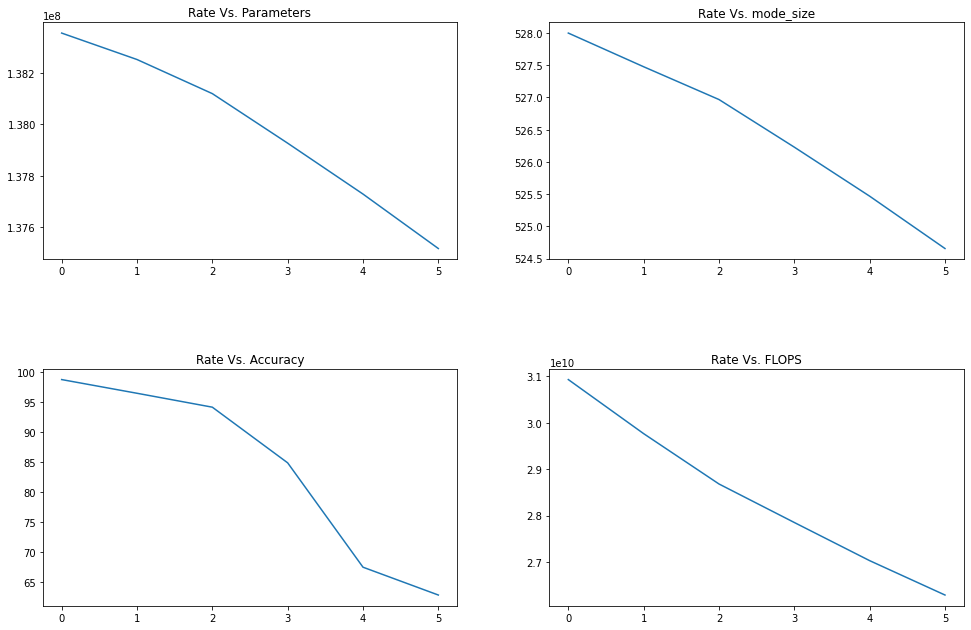

In [ ]:
whole_param = [138357544, 138254142, 138120680, 137926864, 137727836, 137514805]
whole_rate = [0, 1, 2, 3, 4, 5]
whole_acc = [98.8]
whole_size = [528]
whole_flops = [30932349056]

len(whole_rate), len(whole_acc), len(whole_size), len(whole_param), len(whole_flops)

for rate in [1, 2, 3, 4, 5] :
  whole_acc.append(whole_dic[rate/100][0])
  whole_size.append(whole_dic[rate/100][3])
  whole_flops.append(whole_dic[rate/100][2])

fig, a =  plt.subplots(2,2)
a[0][0].plot(whole_rate, whole_param)
a[0][0].set_title('Rate Vs. Parameters')
a[0][1].plot(whole_rate, whole_size)
a[0][1].set_title('Rate Vs. mode_size')
a[1][0].plot(whole_rate, whole_acc)
a[1][0].set_title('Rate Vs. Accuracy')
a[1][1].plot(whole_rate, whole_flops)
a[1][1].set_title('Rate Vs. FLOPS')
fig.tight_layout()
fig.set_size_inches(15, 10)
plt.show()